In [24]:
### given a few pairs of cointegrated coins, use Kalman filtering to calculate the moving slope and intercept between the two coins
# use moving slope and intercepts to calculate spread functions for the pairs
# use the spread functions to calculate points in the time series where spread is 1.96 SD above or below mean
# optional: use this strategy starting with imaginary 1k to plot equity over time. ###

In [108]:
# to get started right now, use stock prices from research paper as an example, insert crypto pairs later.
import tc_user_info
import bitfinex
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import datetime
import time
import os
import zipfile
import seaborn as sns
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')

In [26]:
# read in all the csv files from kaggle dataset of 478 crypto rates 
with zipfile.ZipFile('all_tickers.zip') as z:
    names = [i.upper().strip(".CSV") for i in z.namelist()]
    # dataframes = {filename.split(".")[0]: pd.read_csv(z.open(filename),header=None,encoding="utf8") for filename in names
names

['1INCH-USD',
 '1INCH-UST',
 'AAABBB',
 'AAVE-USD',
 'AAVE-UST',
 'ADABT',
 'ADAF0-USTF0',
 'ADAUSD',
 'ADAUST',
 'AIXUSD',
 'AIXUST',
 'ALBT-USD',
 'ALBT-UST',
 'ALGBT',
 'ALGUSD',
 'ALGUST',
 'AMPBT',
 'AMPF0-USTF0',
 'AMPUSD',
 'AMPUST',
 'ANCUSD',
 'ANCUST',
 'ANTBT',
 'ANTETH',
 'ANTUSD',
 'APEUSD',
 'APEUST',
 'APTUSD',
 'APTUST',
 'ASTUSD',
 'ATOBT',
 'ATOETH',
 'ATOUSD',
 'ATOUST',
 'AVAX-USD',
 'AVAX-UST',
 'AVTUSD',
 'AXSUSD',
 'AXSUST',
 'B21X-USD',
 'B21X-UST',
 'B2MUSD',
 'B2MUST',
 'BALUSD',
 'BALUST',
 'BAND-USD',
 'BAND-UST',
 'BATBT',
 'BATETH',
 'BATUSD',
 'BATUST',
 'BCHABC-USD',
 'BCHN-USD',
 'BEST-USD',
 'BFTUSD',
 'BMIUSD',
 'BMIUST',
 'BMNBT',
 'BMNUSD',
 'BNTUSD',
 'BOOUSD',
 'BOOUST',
 'BOSON-USD',
 'BOSON-UST',
 'BOXUSD',
 'BSVBT',
 'BSVUSD',
 'BTC-CNHT',
 'BTCDOMF0-USTF0',
 'BTCEUR',
 'BTCEUT',
 'BTCF0-USTF0',
 'BTCGBP',
 'BTCJPY',
 'BTCMIM',
 'BTCTRY',
 'BTCUSD',
 'BTCUST',
 'BTCXCH',
 'BTGBT',
 'BTGUSD',
 'BTSE-USD',
 'BTTUSD',
 'DBT',
 'DUSD',
 'DUST',
 'E

In [27]:
def fetch_data(start=1364767200000, stop=1545346740000, symbol='btcusd', interval='1m', tick_limit=1000, step=60000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    start = start - step
    while start < stop:

        start = start + step
        end = start + step
        res = api_v2.candles(symbol=symbol, interval=interval, limit=tick_limit, start=start, end=end)
        data.extend(res)
        print('Retrieving data from {} to {} for {}'.format(pd.to_datetime(start, unit='ms'),
                                                            pd.to_datetime(end, unit='ms'), symbol))
        time.sleep(1.5)
    return data

In [28]:
def fetch_all_data(assetList,resolution):
    dfs=[]
    for coin in assetList:
        bin_size = resolution # This is the resolution at which we request the data
        limit = 1000 # How many data points per call are we asking for
        time_step = 1000 * 60 * limit # From the above calulate the size of each sub querry
        # Fill in the start and end time of interest and convert it to timestamps
        t_start = datetime.datetime(2022, 1, 1, 0, 0)
        t_start = time.mktime(t_start.timetuple()) * 1000
        print(t_start)

        t_stop = datetime.datetime(2022, 11, 24, 23, 59)
        t_stop = time.mktime(t_stop.timetuple()) * 1000

        # Create an bitfinex_api instance
        api_v1 = bitfinex.bitfinex_v1.api_v1()
        pair_data = fetch_data(start=t_start, stop=t_stop, symbol=coin, interval=bin_size, tick_limit=limit, step=time_step)
        ind = [np.ndim(x) != 0 for x in pair_data]
        pair_data = [i for (i, v) in zip(pair_data, ind) if v]

        # Create pandas data frame and clean data
        names = ['time', 'open', 'close', 'high', 'low', 'volume']
        df = pd.DataFrame(pair_data, columns=names)
        df.drop_duplicates(inplace=True)
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
        df.index = pd.to_datetime(df.index, unit='ms')
        df.to_csv(f'1yr_{coin}.csv')
        dfs.append(df)
    return dfs

In [115]:
#dfs = fetch_all_data(["XRPUSD","ZECUSD"],"1m")

In [99]:
eth = pd.read_csv("1yr_ETHUSD.csv", parse_dates = ["time"])
print(eth.shape[0])
btc = pd.read_csv("1yr_BTCUSD.csv",parse_dates = ["time"])
print(btc.shape[0])
ltc = pd.read_csv("1yr_LTCUSD.csv",parse_dates = ["time"])
print(ltc.shape[0])
neo = pd.read_csv("1yr_NEOUSD.csv",parse_dates = ["time"])
print(neo.shape[0])
xmr = pd.read_csv("1yr_XMRUSD.csv",parse_dates = ["time"])
print(xmr.shape[0])
xrp = pd.read_csv("1yr_XRPUSD.csv",parse_dates = ["time"])
print(xrp.shape[0])
zec = pd.read_csv("1yr_ZECUSD.csv",parse_dates = ["time"])
print(zec.shape[0])

471498
471838
352724
190886
196704
410889
220788


In [121]:
btc_prices = btc[["time","close"]].rename(columns = {"close": "btc_price"})

all_prices = btc_prices.merge(eth[["time","close"]].rename(columns = {"close": "eth_price"}), on = "time", how = "left")
all_prices = all_prices.merge(ltc[["time","close"]].rename(columns = {"close": "ltc_price"}), on = "time", how = "left")
all_prices = all_prices.merge(neo[["time","close"]].rename(columns = {"close": "neo_price"}), on = "time", how = "left")
all_prices = all_prices.merge(xmr[["time","close"]].rename(columns = {"close": "xmr_price"}), on = "time", how = "left")
all_prices = all_prices.merge(xrp[["time","close"]].rename(columns = {"close": "xrp_price"}), on = "time", how = "left")
all_prices = all_prices.merge(zec[["time","close"]].rename(columns = {"close": "zec_price"}), on = "time", how = "left")
all_prices = all_prices.set_index("time")
all_prices["eth_price"] = all_prices["eth_price"].interpolate()
all_prices["ltc_price"] = all_prices["ltc_price"].interpolate()
all_prices["neo_price"] = all_prices["neo_price"].interpolate()
all_prices["xmr_price"] = all_prices["xmr_price"].interpolate()
all_prices["xrp_price"] = all_prices["xrp_price"].interpolate()
all_prices["zec_price"] = all_prices["zec_price"].interpolate()
all_prices.to_csv("all_prices.csv")

all_prices["btc_price"] = np.log(all_prices["btc_price"])
all_prices["eth_price"] = np.log(all_prices["eth_price"])
all_prices["ltc_price"] = np.log(all_prices["ltc_price"])
all_prices["neo_price"] = np.log(all_prices["neo_price"])
all_prices["xmr_price"] = np.log(all_prices["xmr_price"])
all_prices["xrp_price"] = np.log(all_prices["xrp_price"])
all_prices["zec_price"] = np.log(all_prices["zec_price"])

In [122]:
all_prices

,btc_price,eth_price,ltc_price,neo_price,xmr_price,xrp_price,zec_price
time,,,,,,,
2022-01-01 08:00:00,10.762219,8.220269,4.997888,3.267628,5.497045,-0.173247,NaN
2022-01-01 08:01:00,10.761259,8.218976,4.995522,3.267409,5.496102,-0.174008,4.997077
2022-01-01 08:02:00,10.761344,8.219030,4.996536,3.267190,5.495815,-0.174056,4.997955
2022-01-01 08:03:00,10.761198,8.219326,4.996874,3.266971,5.495667,-0.174103,4.998270
2022-01-01 08:04:00,10.761492,8.219919,4.996807,3.266751,5.495519,-0.174151,4.998585
...,...,...,...,...,...,...,...
2022-11-26 10:51:00,9.718001,7.108244,4.354424,1.950030,4.927181,-0.897165,3.744704
2022-11-26 10:52:00,9.718061,7.108408,4.355221,1.950016,4.927181,-0.896866,3.744622
2022-11-26 10:53:00,9.718061,7.108244,4.355118,1.950002,4.927181,-0.896567,3.744559


In [123]:
df = all_prices["btc_price"]
df.index.dtype

dtype('<M8[ns]')

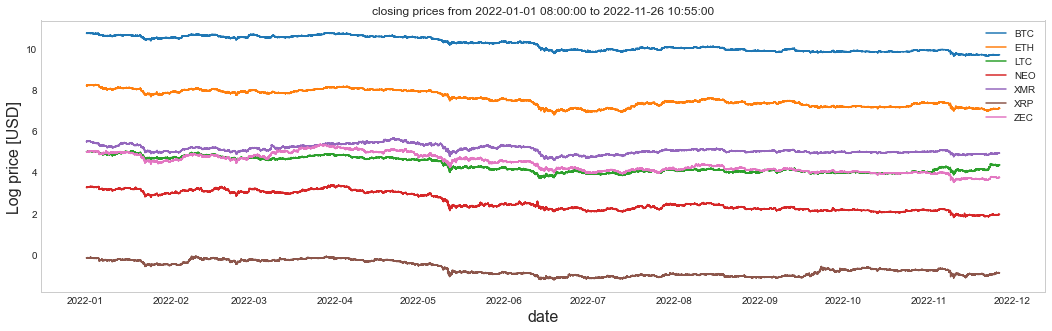

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
ax.plot(all_prices["btc_price"], label = "BTC")
ax.plot(all_prices["eth_price"], label = "ETH")
ax.plot(all_prices["ltc_price"], label = "LTC")
ax.plot(all_prices["neo_price"], label = "NEO")
ax.plot(all_prices["xmr_price"], label = "XMR")
ax.plot(all_prices["xrp_price"], label = "XRP")
ax.plot(all_prices["zec_price"], label = "ZEC")
ax.legend(loc="upper right")
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('Log price [USD]', fontsize=16)
ax.set_title('closing prices from {} to {}'.format(all_prices.index[0], all_prices.index[-1]))
ax.grid()

plt.show()

In [120]:
#linear regression strategy on NEO and XMR
lm = LinearRegression()
lm.fit(all_prices.select(["xmr_price"]),all_prices["neo_price"])
alpha = lm.intercept_
beta = lm.coef_
alpha,beta

ValueError: Found input variables with inconsistent numbers of samples: [1, 471838]